# 第7章: 最短経路アルゴリズム

## 学習目標
- 最短経路問題を理解する
- Dijkstraアルゴリズムを習得する
- Bellman-Fordアルゴリズムを学ぶ
- 全点対最短経路を計算する

## 難易度: 中級〜上級

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

---
## 7.1 最短経路の基礎

In [2]:
# サンプルグラフの作成
G = nx.Graph()
edges = [
    ('A', 'B', 4), ('A', 'C', 2),
    ('B', 'C', 1), ('B', 'D', 5),
    ('C', 'D', 8), ('C', 'E', 10),
    ('D', 'E', 2), ('D', 'F', 6),
    ('E', 'F', 3)
]
G.add_weighted_edges_from(edges)

print(f"ノード: {list(G.nodes())}")
print(f"エッジ数: {G.number_of_edges()}")

ノード: ['A', 'B', 'C', 'D', 'E', 'F']
エッジ数: 9


/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12415 (\N{HIRAGANA LETTER MI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20184 (\N{CJK UNIFIED IDEOGRAPH-4ED8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IP

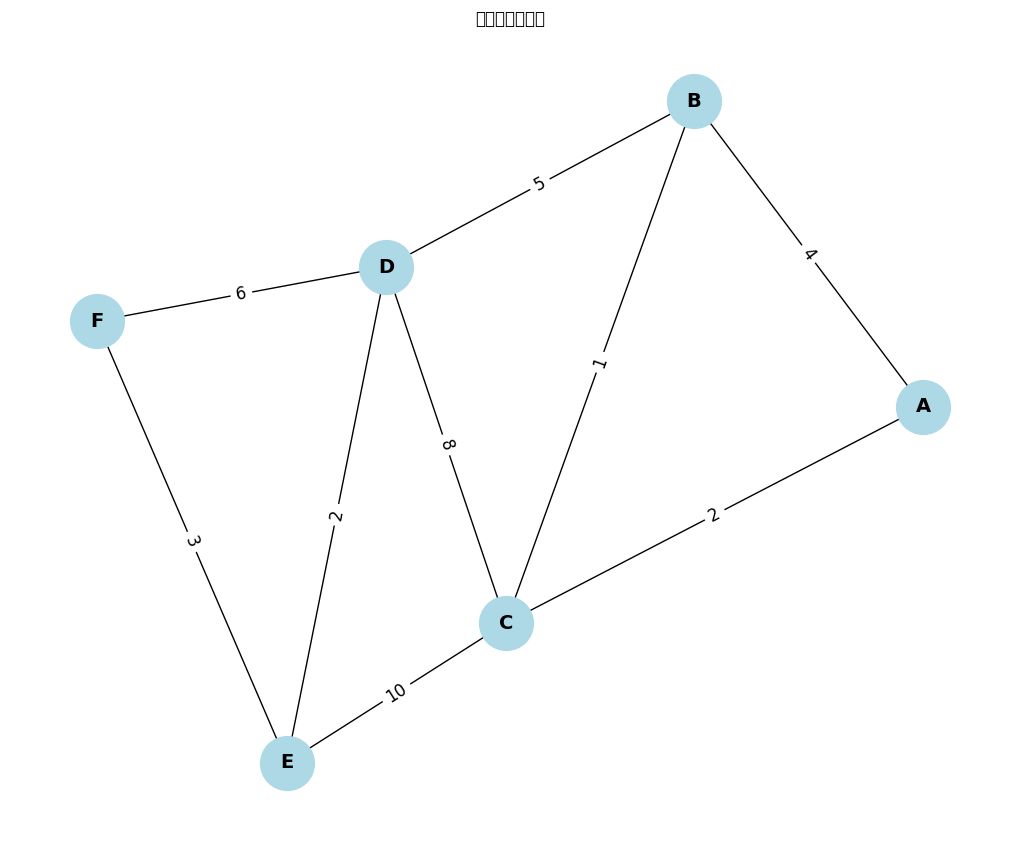

In [3]:
# 可視化
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=1500, font_size=14, font_weight='bold')

# 重みを表示
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

plt.title("重み付きグラフ")
plt.show()

### 7.1.1 単純な最短経路

In [4]:
# 重みなし最短経路（ホップ数最小）
path_unweighted = nx.shortest_path(G, 'A', 'F')
print(f"重みなし最短経路 A→F: {path_unweighted}")
print(f"経路長（ホップ数）: {len(path_unweighted) - 1}")

重みなし最短経路 A→F: ['A', 'B', 'D', 'F']
経路長（ホップ数）: 3


In [5]:
# 重み付き最短経路（距離最小）
path_weighted = nx.shortest_path(G, 'A', 'F', weight='weight')
length_weighted = nx.shortest_path_length(G, 'A', 'F', weight='weight')

print(f"重み付き最短経路 A→F: {path_weighted}")
print(f"総距離: {length_weighted}")

重み付き最短経路 A→F: ['A', 'C', 'B', 'D', 'E', 'F']
総距離: 13


In [6]:
# 経路の詳細表示
print("\n経路の詳細:")
total = 0
for i in range(len(path_weighted) - 1):
    u, v = path_weighted[i], path_weighted[i+1]
    w = G[u][v]['weight']
    total += w
    print(f"  {u} → {v}: 距離 {w}")
print(f"合計距離: {total}")


経路の詳細:
  A → C: 距離 2
  C → B: 距離 1
  B → D: 距離 5
  D → E: 距離 2
  E → F: 距離 3
合計距離: 13


### 7.1.2 最短経路の可視化

/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30701 (\N{CJK UNIFIED IDEOGRAPH-77ED}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32076 (\N{CJK UNIFIED IDEOGRAPH-7D4C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-pac

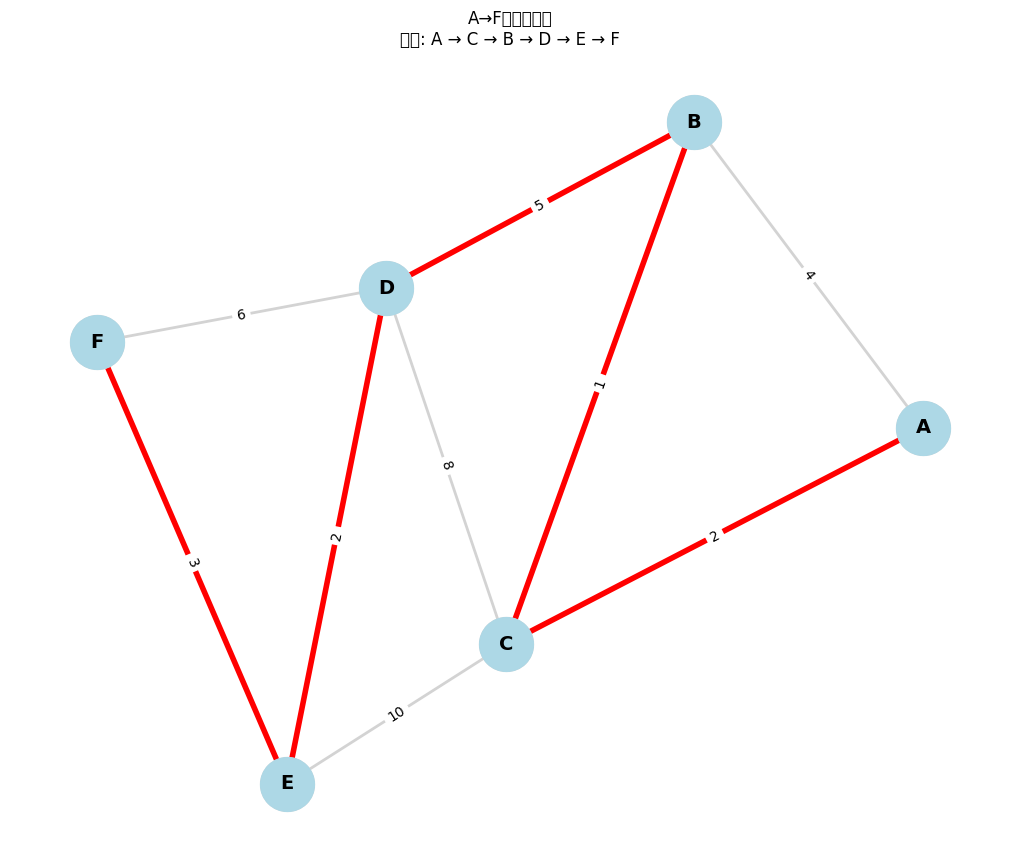

In [7]:
def visualize_path(G, path, title="最短経路"):
    """最短経路を強調表示"""
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    
    # 通常のエッジ
    nx.draw(G, pos, with_labels=True, node_color='lightgray',
            node_size=1500, font_size=14, font_weight='bold',
            edge_color='lightgray', width=2)
    
    # 経路のエッジを強調
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, 
                          edge_color='red', width=4)
    
    # 経路上のノードを強調
    nx.draw_networkx_nodes(G, pos, nodelist=path, 
                          node_color='lightblue', node_size=1500)
    
    # 重みを表示
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    
    plt.title(f"{title}\n経路: {' → '.join(path)}")
    plt.show()

visualize_path(G, path_weighted, "A→Fの最短経路")

---
## 7.2 Dijkstraアルゴリズム

In [8]:
# 単一始点最短経路（Dijkstra）
# Aから全ノードへの最短経路
paths_from_A = nx.single_source_dijkstra_path(G, 'A', weight='weight')
lengths_from_A = nx.single_source_dijkstra_path_length(G, 'A', weight='weight')

print("=== Aから各ノードへの最短経路 ===")
for target, path in paths_from_A.items():
    print(f"  A → {target}: {path} (距離: {lengths_from_A[target]})")

=== Aから各ノードへの最短経路 ===
  A → A: ['A'] (距離: 0)
  A → C: ['A', 'C'] (距離: 2)
  A → B: ['A', 'C', 'B'] (距離: 3)
  A → D: ['A', 'C', 'B', 'D'] (距離: 8)
  A → E: ['A', 'C', 'B', 'D', 'E'] (距離: 10)
  A → F: ['A', 'C', 'B', 'D', 'E', 'F'] (距離: 13)


In [9]:
# dijkstra_path と dijkstra_path_length
path = nx.dijkstra_path(G, 'A', 'F', weight='weight')
length = nx.dijkstra_path_length(G, 'A', 'F', weight='weight')

print(f"Dijkstra経路: {path}")
print(f"Dijkstra距離: {length}")

Dijkstra経路: ['A', 'C', 'B', 'D', 'E', 'F']
Dijkstra距離: 13


In [10]:
# 最短経路と先行ノードを同時に取得
length, path = nx.single_source_dijkstra(G, 'A', target='F', weight='weight')
print(f"距離: {length}, 経路: {path}")

距離: 13, 経路: ['A', 'C', 'B', 'D', 'E', 'F']


---
## 7.3 Bellman-Fordアルゴリズム

負の重みを持つエッジがある場合に使用。

In [11]:
# 負の重みを含む有向グラフ
DG = nx.DiGraph()
DG.add_weighted_edges_from([
    ('A', 'B', 4), ('A', 'C', 2),
    ('B', 'C', -3),  # 負の重み
    ('B', 'D', 2),
    ('C', 'D', 3),
    ('D', 'E', 2)
])

print("負の重みを含むグラフ:")
for u, v, w in DG.edges(data='weight'):
    print(f"  {u} → {v}: {w}")

負の重みを含むグラフ:
  A → B: 4
  A → C: 2
  B → C: -3
  B → D: 2
  C → D: 3
  D → E: 2


In [12]:
# Bellman-Fordアルゴリズム
pred, dist = nx.bellman_ford_predecessor_and_distance(DG, 'A', weight='weight')

print("\n=== Bellman-Ford: Aからの最短距離 ===")
for node, d in sorted(dist.items()):
    print(f"  A → {node}: 距離 {d}")


=== Bellman-Ford: Aからの最短距離 ===
  A → A: 距離 0
  A → B: 距離 4
  A → C: 距離 1
  A → D: 距離 4
  A → E: 距離 6


In [13]:
# 経路を再構築
def reconstruct_path(pred, source, target):
    """先行ノード情報から経路を再構築"""
    path = [target]
    while path[-1] != source:
        path.append(pred[path[-1]][0])
    return list(reversed(path))

path_to_E = reconstruct_path(pred, 'A', 'E')
print(f"\nA→Eの最短経路: {path_to_E}")


A→Eの最短経路: ['A', 'B', 'C', 'D', 'E']


---
## 7.4 全点対最短経路

In [14]:
# Floyd-Warshallアルゴリズム
G = nx.Graph()
G.add_weighted_edges_from([
    ('A', 'B', 1), ('B', 'C', 2), ('A', 'C', 4),
    ('C', 'D', 1), ('D', 'E', 3)
])

# 全点対最短経路長
all_pairs = dict(nx.floyd_warshall(G, weight='weight'))

print("=== 全点対最短経路長（Floyd-Warshall） ===")
nodes = list(G.nodes())
print(f"     {' '.join(f'{n:>5}' for n in nodes)}")
for u in nodes:
    row = [f"{all_pairs[u][v]:5.1f}" for v in nodes]
    print(f"{u}   {' '.join(row)}")

=== 全点対最短経路長（Floyd-Warshall） ===
         A     B     C     D     E
A     0.0   1.0   3.0   4.0   7.0
B     1.0   0.0   2.0   3.0   6.0
C     3.0   2.0   0.0   1.0   4.0
D     4.0   3.0   1.0   0.0   3.0
E     7.0   6.0   4.0   3.0   0.0


In [15]:
# 全点対最短経路（経路も取得）
all_paths = dict(nx.all_pairs_dijkstra_path(G, weight='weight'))

print("\n=== いくつかの最短経路 ===")
print(f"A → E: {all_paths['A']['E']}")
print(f"B → D: {all_paths['B']['D']}")
print(f"A → D: {all_paths['A']['D']}")


=== いくつかの最短経路 ===
A → E: ['A', 'B', 'C', 'D', 'E']
B → D: ['B', 'C', 'D']
A → D: ['A', 'B', 'C', 'D']


---
## 7.5 A*アルゴリズム

ヒューリスティック関数を使用した効率的な経路探索。

In [16]:
# 座標付きグラフ（A*用）
G = nx.Graph()

# ノードに座標を設定
positions = {
    'A': (0, 0), 'B': (1, 2), 'C': (2, 0),
    'D': (3, 2), 'E': (4, 0), 'F': (5, 2)
}

for node, pos in positions.items():
    G.add_node(node, pos=pos)

# ユークリッド距離をエッジの重みに
def euclidean_distance(u, v):
    x1, y1 = positions[u]
    x2, y2 = positions[v]
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

edges = [('A', 'B'), ('A', 'C'), ('B', 'C'), ('B', 'D'), 
         ('C', 'D'), ('C', 'E'), ('D', 'E'), ('D', 'F'), ('E', 'F')]

for u, v in edges:
    G.add_edge(u, v, weight=round(euclidean_distance(u, v), 2))

In [17]:
# ヒューリスティック関数（直線距離）
def heuristic(u, v):
    return euclidean_distance(u, v)

# A*アルゴリズム
path = nx.astar_path(G, 'A', 'F', heuristic=heuristic, weight='weight')
length = nx.astar_path_length(G, 'A', 'F', heuristic=heuristic, weight='weight')

print(f"A*経路: {path}")
print(f"A*距離: {length:.2f}")

A*経路: ['A', 'C', 'E', 'F']
A*距離: 6.24


/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12468 (\N{KATAKANA LETTER GO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabt

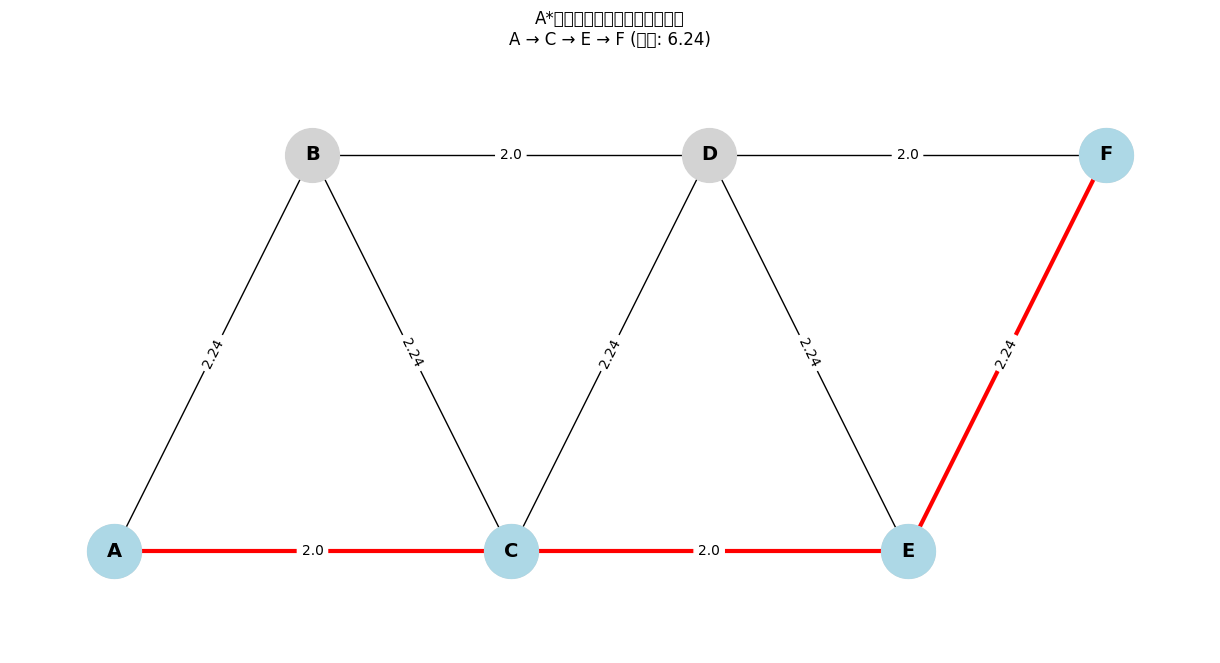

In [18]:
# 可視化
plt.figure(figsize=(12, 6))
pos = positions

# グラフ描画
nx.draw(G, pos, with_labels=True, node_color='lightgray',
        node_size=1500, font_size=14, font_weight='bold')

# 経路を強調
path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3)
nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='lightblue', node_size=1500)

# 重みを表示
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title(f"A*アルゴリズムによる最短経路\n{' → '.join(path)} (距離: {length:.2f})")
plt.axis('equal')
plt.show()

---
## 例題: 地下鉄路線案内

In [19]:
# 地下鉄ネットワーク
subway = nx.Graph()

# 路線データ（駅、次の駅、所要時間）
lines = [
    # 東西線
    ('中野', '高田馬場', 8), ('高田馬場', '早稲田', 3),
    ('早稲田', '飯田橋', 5), ('飯田橋', '大手町', 4),
    ('大手町', '日本橋', 2), ('日本橋', '茅場町', 2),
    
    # 山手線（一部）
    ('池袋', '高田馬場', 5), ('高田馬場', '新宿', 5),
    ('新宿', '渋谷', 7), ('渋谷', '品川', 13),
    ('品川', '東京', 10), ('東京', '秋葉原', 4),
    ('秋葉原', '上野', 4), ('上野', '池袋', 15),
    
    # 接続
    ('東京', '大手町', 2), ('東京', '日本橋', 3)
]

for src, dst, time in lines:
    subway.add_edge(src, dst, time=time)

In [20]:
def find_route(G, start, end):
    """最短経路を検索して表示"""
    try:
        path = nx.shortest_path(G, start, end, weight='time')
        total_time = nx.shortest_path_length(G, start, end, weight='time')
        
        print(f"\n=== {start} → {end} ===")
        print(f"所要時間: {total_time}分")
        print(f"経由駅数: {len(path) - 1}駅")
        print("\n経路:")
        
        for i in range(len(path) - 1):
            time = G[path[i]][path[i+1]]['time']
            print(f"  {path[i]} → {path[i+1]} ({time}分)")
        
        return path, total_time
    except nx.NetworkXNoPath:
        print(f"{start}から{end}への経路が見つかりません")
        return None, None

# 経路検索
find_route(subway, '中野', '品川')
find_route(subway, '池袋', '茅場町')


=== 中野 → 品川 ===
所要時間: 32分
経由駅数: 6駅

経路:
  中野 → 高田馬場 (8分)
  高田馬場 → 早稲田 (3分)
  早稲田 → 飯田橋 (5分)
  飯田橋 → 大手町 (4分)
  大手町 → 東京 (2分)
  東京 → 品川 (10分)

=== 池袋 → 茅場町 ===
所要時間: 21分
経由駅数: 6駅

経路:
  池袋 → 高田馬場 (5分)
  高田馬場 → 早稲田 (3分)
  早稲田 → 飯田橋 (5分)
  飯田橋 → 大手町 (4分)
  大手町 → 日本橋 (2分)
  日本橋 → 茅場町 (2分)


(['池袋', '高田馬場', '早稲田', '飯田橋', '大手町', '日本橋', '茅場町'], 21)

---
## 練習問題

### 練習問題1: 複数経路の探索

以下のグラフで、AからFへの「全ての最短経路」を見つけてください。

```python
G = nx.Graph()
G.add_weighted_edges_from([
    ('A', 'B', 1), ('A', 'C', 1),
    ('B', 'D', 1), ('C', 'D', 1),
    ('B', 'E', 1), ('C', 'E', 1),
    ('D', 'F', 1), ('E', 'F', 1)
])
```

In [21]:
# ここにコードを記述してください



<details>
<summary>解答を見る</summary>

```python
G = nx.Graph()
G.add_weighted_edges_from([
    ('A', 'B', 1), ('A', 'C', 1),
    ('B', 'D', 1), ('C', 'D', 1),
    ('B', 'E', 1), ('C', 'E', 1),
    ('D', 'F', 1), ('E', 'F', 1)
])

# 全ての最短経路を取得
all_shortest_paths = list(nx.all_shortest_paths(G, 'A', 'F', weight='weight'))

print(f"=== A→Fの全ての最短経路 ===")
print(f"経路の数: {len(all_shortest_paths)}")
print(f"最短距離: {nx.shortest_path_length(G, 'A', 'F', weight='weight')}")

for i, path in enumerate(all_shortest_paths, 1):
    print(f"経路{i}: {' → '.join(path)}")

# 可視化
plt.figure(figsize=(10, 8))
pos = {
    'A': (0, 1), 'B': (1, 2), 'C': (1, 0),
    'D': (2, 2), 'E': (2, 0), 'F': (3, 1)
}

nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=1500, font_size=14, font_weight='bold')

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title(f"複数の最短経路\n（{len(all_shortest_paths)}通りの経路）")
plt.show()
```
</details>

### 練習問題2: k番目の最短経路

空手クラブグラフで、ノード0からノード33への「2番目に短い経路」を見つけてください。

ヒント: `nx.shortest_simple_paths()`を使用

In [22]:
# ここにコードを記述してください



<details>
<summary>解答を見る</summary>

```python
G = nx.karate_club_graph()

# k番目までの最短経路を取得
k = 5
paths = list(nx.shortest_simple_paths(G, 0, 33))[:k]

print(f"=== ノード0→33の上位{k}経路 ===")
for i, path in enumerate(paths, 1):
    print(f"{i}番目: {path} (長さ: {len(path)-1})")

# 2番目の経路
second_shortest = paths[1] if len(paths) > 1 else None
print(f"\n2番目に短い経路: {second_shortest}")

# 可視化
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_color='lightgray',
        node_size=500, font_size=8, alpha=0.5)

# 最短経路（青）
path1_edges = [(paths[0][i], paths[0][i+1]) for i in range(len(paths[0])-1)]
nx.draw_networkx_edges(G, pos, edgelist=path1_edges, edge_color='blue', width=3)

# 2番目（赤）
path2_edges = [(paths[1][i], paths[1][i+1]) for i in range(len(paths[1])-1)]
nx.draw_networkx_edges(G, pos, edgelist=path2_edges, edge_color='red', width=3, style='dashed')

plt.title("最短経路（青）と2番目の経路（赤点線）")
plt.show()
```
</details>

---
## 7.6 章のまとめ

この章では以下を学びました：

1. **基本的な最短経路**: `shortest_path()`, `shortest_path_length()`
2. **Dijkstraアルゴリズム**: 非負の重みに対して効率的
3. **Bellman-Fordアルゴリズム**: 負の重みにも対応
4. **全点対最短経路**: Floyd-Warshall
5. **A*アルゴリズム**: ヒューリスティック探索

### 次章の予告
次章では、ネットワークの中心性指標について学びます。